In [1]:
!pip install -U accelerate
!pip install -U transformers
!pip install -U pandas
!pip install -U scikit-learn
!pip install -U torch torchvision torchaudio

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
import pandas as pd
df = pd.read_csv("./data/data.csv", usecols=["Description", "Genre"])

In [3]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
seed = 42

## Data Analysis

In [4]:
df.head()

,Genre,Description
0,"Action,Adventure,Sci-Fi",A group of intergalactic criminals are forced ...
1,"Adventure,Mystery,Sci-Fi","Following clues to the origin of mankind, a te..."
2,"Horror,Thriller",Three girls are kidnapped by a man with a diag...
3,"Animation,Comedy,Family","In a city of humanoid animals, a hustling thea..."
4,"Action,Adventure,Fantasy",A secret government agency recruits some of th...


In [5]:
# 1k rows
df.shape

(1000, 2)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Genre        1000 non-null   object
 1   Description  1000 non-null   object
dtypes: object(2)
memory usage: 15.8+ KB


In [7]:
# 0 duplicates
df.duplicated().sum()

np.int64(0)

<Axes: ylabel='Frequency'>

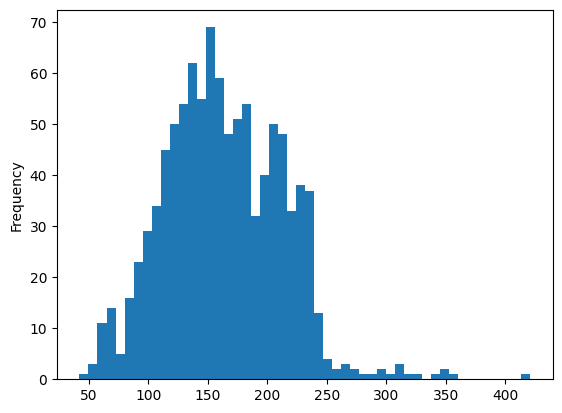

In [8]:
# plot number of characters -> in english 4-5 characters per token. So all descriptions have <~ 100 tokens.
# since bert models have a cap of 512 tokens we are safe
df['Description'].str.len().plot.hist(bins=50)

In [9]:
df['Genre'] = df['Genre'].str.split(",")

<Axes: ylabel='Frequency'>

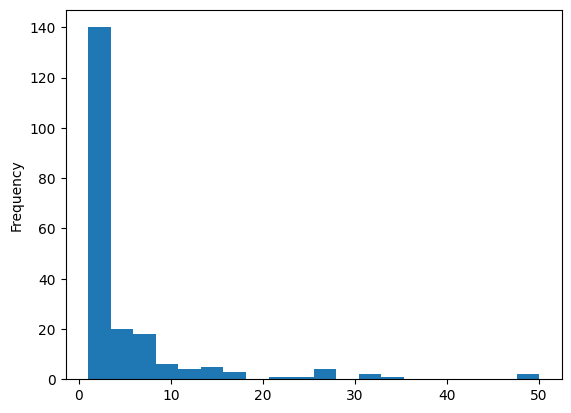

In [10]:
# This is for unique combinations of genres
df['Genre'].value_counts().plot.hist(bins=20)

In [11]:
genre_counts = []
for genl in df['Genre']:
    genre_counts += genl
# dataset is not balanced
pd.Series(genre_counts).value_counts() 

Drama        513
Action       303
Comedy       279
Adventure    259
Thriller     195
Crime        150
Romance      141
Sci-Fi       120
Horror       119
Mystery      106
Fantasy      101
Biography     81
Family        51
Animation     49
History       29
Sport         18
Music         16
War           13
Western        7
Musical        5
Name: count, dtype: int64

### Encoding

In [12]:
from sklearn.preprocessing import MultiLabelBinarizer

encoder = MultiLabelBinarizer()
labels = encoder.fit_transform(df['Genre']).astype('float32')

In [13]:
texts = df['Description'].tolist()

**We could do preprocessing here but will choose not to do it**

## Model Building
1. Import transformer libraries
2. Make custom dataset
3. tokenization
4. build multi-label metrics

In [14]:
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset

In [15]:
torch.cuda.is_available()

True

In [16]:
base_model = "distilbert-base-uncased"
tokenizer = DistilBertTokenizer.from_pretrained(base_model)
model = DistilBertForSequenceClassification.from_pretrained(base_model, num_labels=len(labels[0]), problem_type="multi_label_classification")
MAX_LEN = 128

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
# pytorch style dataset
#labels2 = torch.tensor(labels)
#encoded_texts = tokenizer(texts, truncation=True, padding="max_length", max_length=MAX_LEN, return_tensors='pt')
#dataset = torch.utils.data.TensorDataset(encoded_texts['input_ids'], encoded_texts['attention_mask'], labels2)
#train_size = int(0.8 * len(dataset))
#train_ds, test_ds = torch.utils.data.random_split(dataset, [train_size, len(dataset) - train_size])
#pyset = {
#    'train': train_ds,
#    'test': test_ds,
#}

In [27]:
# transformers style dataset
from datasets import Dataset
def preprocess(examples):
    return  tokenizer(examples['text'], truncation=True, padding="max_length", max_length=MAX_LEN, return_tensors='pt')
data = {
   "text": texts,
    "label": labels,
}
hugset = Dataset.from_dict(data)
tokenized = hugset.map(preprocess,batched=True)
dataset = tokenized.train_test_split(test_size=0.2,seed=seed)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [25]:
dataset['train']

Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 800
})

## Training

In [36]:
from transformers import TrainingArguments, Trainer
threshold = 0.3
args = TrainingArguments(
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    output_dir="./results",
    num_train_epochs=5,
    save_steps=1000,
    save_total_limit=2,
)

trainer = Trainer(model=model,train_dataset=dataset['train'],eval_dataset=dataset['test'],compute_metrics=compute_metrics)

In [37]:
trainer.train()

Step,Training Loss


TrainOutput(global_step=300, training_loss=0.19020270029703776, metrics={'train_runtime': 51.2922, 'train_samples_per_second': 46.791, 'train_steps_per_second': 5.849, 'total_flos': 79505952768000.0, 'train_loss': 0.19020270029703776, 'epoch': 3.0})

#### Multi Label Classification Evaluation Metrics

In [20]:
import numpy as np
from sklearn.metrics import roc_auc_score, f1_score, hamming_loss
from transformers import EvalPrediction
import torch

def multi_labels_metrics(predictions,labels, threshold = threshold):
    sigmoid = torch.nn.Sigmoid()
    probabilities = sigmoid(torch.Tensor(predictions))
    y_pred = np.zeros(probabilities.shape)
    y_pred[np.where(probabilities>=threshold)] = 1
    y_true = labels

    f1 = f1_score(y_true, y_pred, average='macro')
    roc_auc = roc_auc_score(y_true, y_pred)
    hamming = hamming_loss(y_true, y_pred)
    metrics = {
    "roc_auc": roc_auc,
    "hamming_loss": hamming,
    "f1": f1,
    }
    return metrics

def compute_metrics(p:EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
    result = multi_labels_metrics(predictions=preds, labels=p.label_ids)
    return result


In [31]:
trainer.evaluate()

{'eval_loss': 0.2720451056957245,
 'eval_roc_auc': 0.5897083999782109,
 'eval_hamming_loss': 0.1195,
 'eval_f1': 0.24124612965434059,
 'eval_runtime': 1.3682,
 'eval_samples_per_second': 146.18,
 'eval_steps_per_second': 18.273,
 'epoch': 3.0}

In [33]:
# save model
trainer.save_model("model-distilbert-finetuned-imdb-multi-label")

In [32]:
# save multilabel binarizer
import pickle
with open("multi-label-binarizer.pkl", "wb") as f:
    pickle.dump(encoder, f)

## Predictions

In [34]:
# text for Gladiator II - Action, Adventure, Drama
text = "After his home is conquered by the tyrannical emperors who now lead Rome, Lucius is forced to enter the Colosseum and must look to his past to find strength to return the glory of Rome to its people."
encoding = tokenizer(text, return_tensors='pt')
encoding.to(trainer.model.device)

outputs = trainer.model(**encoding)
outputs

SequenceClassifierOutput(loss=None, logits=tensor([[ 0.9558,  0.7949, -2.2888, -2.8874, -1.7304, -2.4372, -1.2439, -2.1465,
         -1.3178, -2.8257, -2.2345, -3.5340, -3.5516, -2.5347, -2.9208, -1.0341,
         -2.9938, -1.9699, -3.4276, -3.5574]], device='cuda:0',
       grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [40]:
sigmoid = torch.nn.Sigmoid()
probs = sigmoid(outputs.logits[0].cpu())
preds = np.zeros(probs.shape)
preds[np.where(probs>=threshold)] = 1
preds

array([1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

In [41]:
encoder.inverse_transform(preds.reshape(1,-1))

[('Action', 'Adventure')]